# River Sediment Data - Exploratory Data Analysis (EDA)

Original dataset collected by Nez Perce-Clearwater National Forest personnel in northern Idaho, and stored, with sediment calculations, in Excel. 

This dataset includes more than three decades of sediment data for a single waterway in the Nez Perce-Clearwater National Forest.

This notebook examines dataset statistics, correlations and assumptions in preparation for data analysis and predictive modeling.

See **_River Sediment Data - Raw Data Import_** notebook in this repo for the raw data imported from Excel, cleaned up and saved as the CSV file loaded here.

Dataset processing and analysis by Laura Williams. Laura Williams is not a Forest Service employee, and this data processing and analysis are not necessarily the analysis nor opinion of the US Forest Service.

In [1]:
# import packages
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [2]:
filename = 'Data/sed_data_full.csv'
sed_data = pd.read_csv(filename, 
                       encoding='UTF-8', 
                       index_col='DateCollected',
                       parse_dates = ['DateCollected'])

In [3]:
print("Rows:", sed_data.shape[0], "Columns:", sed_data.shape[1])

Rows: 2697 Columns: 11


In [4]:
sed_data.head()

,Sample_Freq_Hrs,Filter_Tar,Filter_Sed,Sed,Sed_Calc,Sed_Check,Vol_ml,Sedload,Sedload_Calc,Sedload_Check,NTU
DateCollected,,,,,,,,,,,
1983-04-01,NaN,0.1104,0.1108,0.0004,0.0004,True,339.0,1.1799,1.1800,True,NaN
1983-04-02,NaN,0.1119,0.1123,0.0004,0.0004,True,337.0,1.1869,1.1870,True,NaN
1983-04-03,NaN,0.1118,0.1121,0.0003,0.0003,True,338.0,0.8876,0.8876,True,NaN
1983-04-04,NaN,0.1106,0.1185,0.0079,0.0079,True,185.0,42.7027,42.7000,True,NaN
1983-04-05,NaN,0.1089,0.1099,0.0010,0.0010,True,206.0,4.8544,4.8540,True,NaN


In [5]:
print("Confirm data types are correct (compare with data saved in Raw Data Import notebook):")
print("Index data type:")
print(sed_data.index.dtype, '\n')
print("Column data types:")
print(sed_data.dtypes)

Confirm data types are correct (compare with data saved in Raw Data Import notebook):
Index data type:
datetime64[ns] 

Column data types:
Sample_Freq_Hrs    float64
Filter_Tar         float64
Filter_Sed         float64
Sed                float64
Sed_Calc           float64
Sed_Check             bool
Vol_ml             float64
Sedload            float64
Sedload_Calc       float64
Sedload_Check         bool
NTU                float64
dtype: object


## Summary statistics and variable exploration

###  Examine the index of sample collection dates

In [6]:
print("Are all dates in the index unique?")
print(sed_data.index.is_unique)

Are all dates in the index unique?
False


In [7]:
print("Number of rows in the dataset:", sed_data.shape[0])
print("Number of unique dates in the index:", len(sed_data.index.unique()))

Number of rows in the dataset: 2697
Number of unique dates in the index: 2402


In [8]:
all_multiples = sed_data[sed_data.index.duplicated(keep=False)==True]
print("The number of dates that have more than one collection sample recorded is:")
print(len(all_multiples.index.unique()))

The number of dates that have more than one collection sample recorded is:
187


In [9]:
print("The number of samples collected on the same day do not have data for Sample_Frequency_Hrs is:")
all_multiples.Sample_Freq_Hrs.isna().sum()


The number of samples collected on the same day do not have data for Sample_Frequency_Hrs is:


202

**Discussion:**  
Data confirms that sometimes multiple water samples are collected on the same date, which is expected during and immediately after rain and storm events, when sediment concentration is expected to be changing quickly.

Not all samples collected on the same date have recorded the frequency in hours between samples (as `Sample_Freq_Hrs`).  It may be necessary to infer hourly frequency values for some data analysis.  

### Examine the range of each variable.

In [10]:
cols = sed_data.columns.tolist()
print('{0:<40} {1:^20} {2:^15}'.format('Variable Name', 'Minimum Value', "Maximum Value"))
# Data Index
print('{0:<40} {1:^20} {2:^15}'.format(sed_data.index.name, 
                                       min(sed_data.index).strftime('%B %d, %Y'), 
                                       max(sed_data.index).strftime('%B %d, %Y')
                                      ))
# Each column
for i in range(len(cols)):
    print('{0:<40} {1:^20} {2:^15}'.format(cols[i], sed_data[cols[i]].min(), sed_data[cols[i]].max()))

Variable Name                               Minimum Value      Maximum Value 
DateCollected                               April 01, 1983     June 26, 2015 
Sample_Freq_Hrs                                  6.0                6.0      
Filter_Tar                                     0.00853            1.6705     
Filter_Sed                                      0.0254            1.7453     
Sed                                             0.0001            0.6976     
Sed_Calc                                 -0.5939000000000001      0.6976     
Sed_Check                                         0                  1       
Vol_ml                                           30.0             1900.0     
Sedload                                         0.1333           6407727.0   
Sedload_Calc                                    -802.6            1575.0     
Sedload_Check                                     0                  1       
NTU                                              0.01           

**Discussion:**  
`Sed_Calc` and `Sedload_Calc` negative values are inaccurate, the lowest value for sediment measurement is zero.

The presence of zeros (the numerical equivalent of False) in the `Sed_Check` and `Sedload_Check` columns indicate that some calculation checks are bad, which could result in the out of range negative calculations found above.  

Examine and remove all rows with either one or both bad calculation checks and evalutate impact to dataset:

In [11]:
bads_sed = sed_data[sed_data.Sed_Check == 0]
bads_sedload = sed_data[sed_data.Sedload_Check == 0]
print("Number of samples with bad Sed_Check:", bads_sed.shape[0])
print("Number of samples with bad Sedload_Check':", bads_sedload.shape[0])

Number of samples with bad Sed_Check: 57
Number of samples with bad Sedload_Check': 77


In [12]:
with_bad = sed_data.shape[0]
sed_data = sed_data[(sed_data.Sed_Check == 1) & 
                    (sed_data.Sedload_Check == 1)]
without_bad = sed_data.shape[0]

In [13]:
print("Number of data points removed:", with_bad-without_bad)
print("Percent of total dataset removed:", str(round(((with_bad-without_bad)/with_bad)*100, 4)) + '%')

Number of data points removed: 81
Percent of total dataset removed: 3.0033%


In [14]:
# To review all rows with bad calculations, uncomment the following lines
#pd.set_option('display.max_rows', 100)
#pd.concat([bads_sedload, bads_sed]).drop_duplicates()

In [15]:
print('{0:<40} {1:^20} {2:^15}'.format('Variable Name', 'Minimum Value', "Maximum Value"))
# Data Index
print('{0:<40} {1:^20} {2:^15}'.format(sed_data.index.name, 
                                       min(sed_data.index).strftime('%B %d, %Y'), 
                                       max(sed_data.index).strftime('%B %d, %Y')
                                      ))
# Each column
for i in range(len(cols)):
    print('{0:<40} {1:^20} {2:^15}'.format(cols[i], sed_data[cols[i]].min(), sed_data[cols[i]].max()))

Variable Name                               Minimum Value      Maximum Value 
DateCollected                               April 01, 1983     June 26, 2015 
Sample_Freq_Hrs                                  6.0                6.0      
Filter_Tar                                      0.0232            1.5141     
Filter_Sed                                      0.0254            1.7453     
Sed                                             0.0001            0.6976     
Sed_Calc                                 9.9999999999989e-05      0.6976     
Sed_Check                                         1                  1       
Vol_ml                                           30.0             1900.0     
Sedload                                          0.2             1574.7178   
Sedload_Calc                                     0.2              1575.0     
Sedload_Check                                     1                  1       
NTU                                              0.01           

**Discussion:**  
Removing 3% of the dataset to examine overall summary statistics is acceptable.  However, the sample size per year is small (average of 100 samples each year), and some rows have one bad calcuation, but not both.  For data analysis of data subsets (such as a year or a storm event) where only one of the `Sed` or `Sedload` calculations are used, it is recommended to remove only the rows with bad calculations that are relevent to that data analysis. 

Ideally, a hydrologist with domain experience should review the variable ranges above after the bad data was removed to confirm they are as expected.

Additionally, a hydrologist could review the datapoints with bad calculations and assess if it's possible to correct the calculations to approve including some or all of those data points in the dataset.

### Look for missing data

In [16]:
print('{0:<40} {1:^30}'.format('Variable Name', 'Total Samples with Missing Data'))
# Data Index
print('{0:<40} {1:^30}'.format(sed_data.index.name, 
                               pd.isnull(sed_data.index).sum()
                              ))
# Each column
for i in range(len(cols)):
    print('{0:<40} {1:^30}'.format(cols[i], pd.isnull(sed_data[cols[i]]).sum()))

Variable Name                            Total Samples with Missing Data
DateCollected                                          0               
Sample_Freq_Hrs                                       825              
Filter_Tar                                             34              
Filter_Sed                                             34              
Sed                                                    0               
Sed_Calc                                               0               
Sed_Check                                              0               
Vol_ml                                                 0               
Sedload                                                0               
Sedload_Calc                                           0               
Sedload_Check                                          0               
NTU                                                   677              


**Discussion:**  
* The absence of `Sample_Freq_Hrs` may require inference for dates for which multiple samples were collected in one day.  This value is not relevant for dates on which only one sample was collected.
* `Filter_Tar` and `Filter_Sed` are used to calcuate `Sed`.  It's unclear why those values would be absent, though perhaps they were simply omitted through oversight. Any data analysis not including these two values can ignore that these missing values exist, unless review of those data points indicates otherwise.
* `NTU` is a measurement by a device that was not used to measure all samples.  This does not impact other variables.

Metadata for each variable, as defined in the original Excel spreadsheet:
* **DateCollected**: Date the sample was collected
* **Sample_Freq_Hrs**: The frequency at which the sample was collected
* **Filter_Tar**: The weight of the fluid sample after filtering
* **Filter_Sed**: The weight of the fluid sample after filtering plus the filtered sediment
* **Sed:** The documented weight of the sediment calculated from the fluid minus the fluid w/ sediment
* **Sed_Calc:** The excel calculated weight of the sediment calculated from the fluid minus the fluid w/ sediment
* **Sed_Check:** The automatic check that examines if the sediment_grams field is the same as the sediment_calc_grams, and identifes it as good or bad, indicating if the values were same within +- 5% or not the same.
* **Vol_ml:** The amount of water in each sample bottle that was tested
* **Sedload:** The calculated and documented sediment load for each sample bottle
* **Sedload_Calc:** The excel calculated sediment load for each sample bottle
* **Sedload_Check:** The automatic check that examines if the Sedload field is the same as the Sedload_Calc grams, and identifes it as good or bad, indicating if the values were same within +- 5% or not the same.
* **NTU:** The device reading that indicates the Nephelometric Turbidity Units

### Explore summary statistics of numerical variables

In [17]:
numeric_cols = ['Sample_Freq_Hrs', 'Filter_Tar', 'Filter_Sed', 'Sed', 'Sed_Calc', 
                'Vol_ml', 'Sedload', 'Sedload_Calc', 'NTU']

In [18]:
sed_data[numeric_cols].describe()

,Sample_Freq_Hrs,Filter_Tar,Filter_Sed,Sed,Sed_Calc,Vol_ml,Sedload,Sedload_Calc,NTU
count,1791.0,2582.000000,2582.000000,2616.000000,2616.000000,2616.000000,2616.000000,2616.000000,1939.000000
mean,6.0,0.284502,0.290244,0.005683,0.005684,406.075306,14.423927,14.419520,2.115050
std,0.0,0.395867,0.398428,0.020291,0.020300,133.151226,45.493395,45.476643,2.443522
min,6.0,0.023200,0.025400,0.000100,0.000100,30.000000,0.200000,0.200000,0.010000
25%,6.0,0.083100,0.085300,0.001200,0.001200,354.750000,3.160000,3.158000,1.000000
50%,6.0,0.085700,0.092550,0.002300,0.002300,400.000000,5.779050,5.776000,1.460000
75%,6.0,0.215075,0.217275,0.004700,0.004700,450.000000,12.261750,12.250000,2.395000
max,6.0,1.514100,1.745300,0.697600,0.697600,1900.000000,1574.717800,1575.000000,44.500000


**Discussion:**  
Summary statistics do not look unusual, a hydrologist familiar with the data should review to confirm that nothing these summary statistics indicates potential bad data.

### Are  numeric variables normally distributed?
Visual distribution shown on log scale for visual clarity

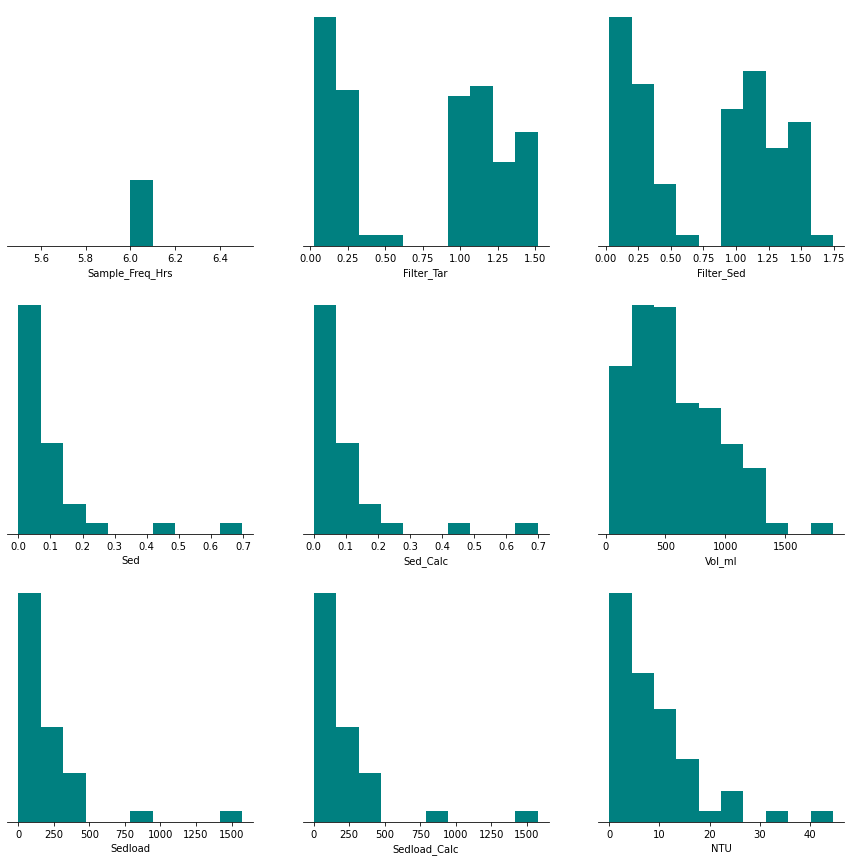

In [19]:
fig = plt.figure(figsize = (15,15)) 
for i in range(len(numeric_cols)):
    ax = fig.add_subplot(3, 3, i+1)
    ax.hist(sed_data[numeric_cols[i]].dropna(), log=True,  color='teal')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.set_yticklabels('')
    ax.set_xlabel(numeric_cols[i])

Numeric mean, median and mode of each variable:

In [20]:
print('{0:<35} {1:^18} {2:^10} {3:^10}'.format('Variable Name', 'Mean', 'Median', 'Mode'))
for i in range(len(numeric_cols)):
    print('{0:<35} {1:>18.10f} {2:>10.4f} {3:>10.4f}'.format(numeric_cols[i], 
                                                   sed_data[numeric_cols[i]].mean(), 
                                                   sed_data[numeric_cols[i]].median(),
                                                   float(sed_data[numeric_cols[i]].mode()) \
                                          ))


Variable Name                              Mean          Median      Mode   
Sample_Freq_Hrs                           6.0000000000     6.0000     6.0000
Filter_Tar                                0.2845021301     0.0857     0.0844
Filter_Sed                                0.2902441518     0.0925     0.0858
Sed                                       0.0056826261     0.0023     0.0012
Sed_Calc                                  0.0056843272     0.0023     0.0015
Vol_ml                                  406.0753058104   400.0000   390.0000
Sedload                                  14.4239273777     5.7790     5.0000
Sedload_Calc                             14.4195199924     5.7760     5.0000
NTU                                       2.1150504384     1.4600     1.0000


**Discussion:**  

Visual and numerical data confirm that data is not normally distributed.  This is expected given that waterways typically have a lower base sediment load for most days of the year, and significantly higher and widely variable sediment loads immediately after significant storm or rain events.  

The median and mode for the sediment and sediment load variables in particular are closer together in value than the mean, which also points to outlier measurements from storms that would be expected to influence the mean more than the median or the mode.  

Non-parametric statistical tests may be best for analysis and predictive models. Outliers, which are essential to interpreting this dataset, can make regression or other parametric analyses less accurate.

### Correlations between variables

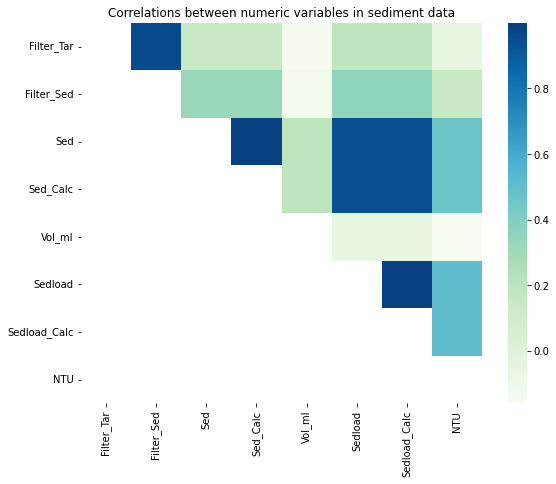

In [21]:
# remove non-relevant sample_frequency_hours variable
corr_cols = numeric_cols.copy()
corr_cols.remove('Sample_Freq_Hrs')
correlation_matrix=sed_data[corr_cols].corr(method='spearman')
# plot heatmap for correlations
def heatmap(matrix):
    plt.figure(figsize=(9,7))
    mask = np.tril(np.ones_like(matrix))
    sns.heatmap(matrix, mask=mask, cmap="GnBu") 
    plt.title("Correlations between numeric variables in sediment data")
    plt.show()
heatmap(correlation_matrix)

# figsize=(8,6)

In [22]:
# create list of correlated pairs
correlations=[]
for i in correlation_matrix.index:
    for j in correlation_matrix.columns:
            if i!=j:
                correlations.append((i,j,correlation_matrix[i][j]))

In [23]:
# print sorted list of highest positive correlations
positive_corr = [i for i in correlations if i[2] >= 0.5]
pos_sort=sorted(positive_corr,reverse=True,key=lambda k: k[2])
print('Highly Positive Correlations: \n')
print('{0:<35} {1:<35} {2:<20}'.format('First Variable', 'Second Variable', "Correlation Between Variables"))
for i in range(len(pos_sort)):
    # print only every other correlation to avoid listing duplicates
    if i%2 == 0:
        print('{0:<35} {1:<35} {2:<20}'.format(pos_sort[i][0], pos_sort[i][1], pos_sort[i][2]))

Highly Positive Correlations: 

First Variable                      Second Variable                     Correlation Between Variables
Sedload                             Sedload_Calc                        0.9999949300219428  
Sed                                 Sed_Calc                            0.9999071275132436  
Filter_Tar                          Filter_Sed                          0.95620006321012    
Sed                                 Sedload_Calc                        0.9435347013752658  
Sed                                 Sedload                             0.9435133723908613  
Sed_Calc                            Sedload_Calc                        0.943462604456805   
Sed_Calc                            Sedload                             0.9434406384399405  
Sedload_Calc                        NTU                                 0.502304671784149   
Sedload                             NTU                                 0.5022695122391416  


**Discussion:**  

There are no unexpected variable correlations. Correlations between Sediment and Sediment Load measurements and calculations are expected to be high.  Sediment load and NTU measurements are expected to be somewhat correlated, but long-term averages of these two variables are less likely to be highly correlated than during storm events.

A hydrologist should review the correlations to confirm they are as expected.

Non-parametric Spearman correlation test was used to evaluate correlations. The Spearman test is not adversely affected by outliers and is the most common alternative to the Pearson correlation when data is not normally distributed. 

## Explore  trends

Water samples were collected manually, meaning a person had to physically hike to a site to collect the sample.  As a result, data collection dates have irregular frequency.  

Later a base sediment load level will be interpolated for dates on which no sample was collected. Below are overall trends of the data without interpolation.

### Monthly trends

In [24]:
month_trend = sed_data.groupby(sed_data.index.month).Sedload.mean()

In [25]:
x_tick_labels = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
# Note: explicit month labels are not inferred automatically given the irregular frequency of the data collection
titledict = {'fontsize': 'x-large',
             'fontweight': 'ultralight',
             'color': 'black',
             'verticalalignment': 'baseline',
             'horizontalalignment': 'center'}

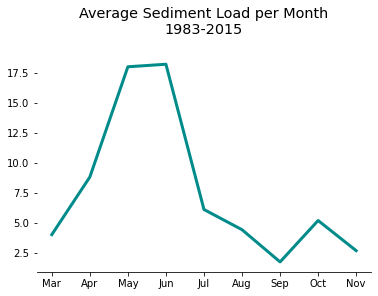

In [26]:
fig_monthly = plt.figure()
ax = fig_monthly.add_subplot(1, 1, 1)
ax.plot(month_trend, color='darkcyan', linewidth=3.0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
# ax.set_yticks([])
ax.set_xticks(month_trend.index)
ax.set_xticklabels(x_tick_labels)
ax.set_title('Average Sediment Load per Month\n1983-2015', fontdict=titledict, pad=20)
plt.show()

**Discussion:**  
The average sediment load over the course of each year is expected to rise substantially with snowmelt in late spring and early summer as is shown here.

No data were collected during winter months of December, January, or February for any years in this dataset.  This is presumably a standard operating procedure given that waterways may be frozen, unreachable due to snow, and that flow and sediment loads are not expected to change substantially during winter months.

This data naturally has outliers that represent storm events and other contributors to high sediment load.  Exploring the median and smaller quantile sediment load in addition to will minimize the impact of outliers and begin to explore if trends exist in the base sediment as well as the storm events.

In [27]:
month_trend_median = sed_data.groupby(sed_data.index.month).Sedload.median()
month_trend_1q = sed_data.groupby(sed_data.index.month).Sedload.quantile(q=0.25)

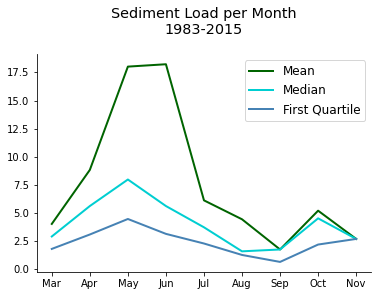

In [28]:
fig_month_all = plt.figure()
ax = fig_month_all.add_subplot(1, 1, 1)

ax.plot(month_trend, color='darkgreen', linewidth=2.0, label="Mean")
ax.plot(month_trend_median, color='darkturquoise', linewidth=2.0, label="Median")
ax.plot(month_trend_1q, color='steelblue', linewidth=2.0, label="First Quartile")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks(month_trend.index)
ax.set_xticklabels(x_tick_labels)
ax.set_title('Sediment Load per Month\n1983-2015', fontdict=titledict, pad=20)
ax.legend(fontsize='large')

plt.show()

The trend is mostly similar for the first quartile and median as it is for the mean, and expectedly more pronounced in the mean than in the median or first quartile. The October and November trends in the first quartile do not match the mean and median.  

Below it's shown that the number of samples collected in October and November (and possibly August and September) are too small to use for accurate trend analysis.  The single November sample explains why the mean, median, and first quantile converge on the exact same value.

In [29]:
pd.DataFrame(sed_data.groupby(sed_data.index.month).Sedload.count())

,Sedload
DateCollected,
3,45
4,547
5,814
6,890
7,274
8,12
9,20
10,13
11,1


### Yearly trends

In [30]:
year_trend = sed_data.groupby(sed_data.index.year).Sedload.mean()

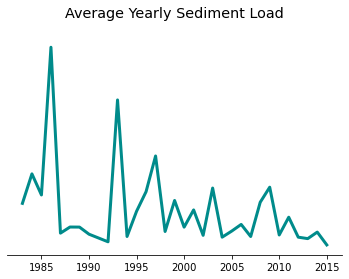

In [31]:
fig_yearly = plt.figure()
ax = fig_yearly.add_subplot(1, 1, 1)
ax.plot(year_trend, color='darkcyan', linewidth=3.0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_yticks([])
ax.set_title('Average Yearly Sediment Load', fontdict=titledict, pad=20)
plt.show()

Another way to look at this is to report the average of rolling window of multiple years.  Two years is used for this plot.

In [32]:
rolling_yearly = sed_data.Sedload.rolling(window=720).mean()

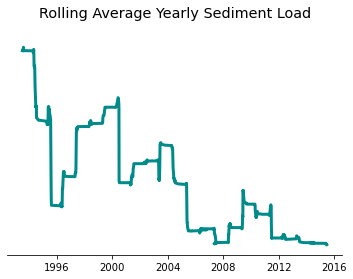

In [33]:
fig_rolling_yearly = plt.figure()
ax = fig_rolling_yearly.add_subplot(1, 1, 1)
ax.plot(rolling_yearly, color='darkcyan', linewidth=3.0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_yticks([])
ax.set_title('Rolling Average Yearly Sediment Load', fontdict=titledict, pad=20)
plt.show()

Yearly trends can also be plotted with the median and first quartile.

In [34]:
year_trend_median = sed_data.groupby(sed_data.index.year).Sedload.median()
year_trend_1q = sed_data.groupby(sed_data.index.year).Sedload.quantile(q=0.25)

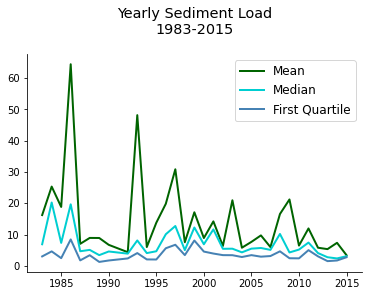

In [35]:
fig_year_all = plt.figure()
ax = fig_year_all.add_subplot(1, 1, 1)

ax.plot(year_trend, color='darkgreen', linewidth=2.0, label="Mean")
ax.plot(year_trend_median, color='darkturquoise', linewidth=2.0, label="Median")
ax.plot(year_trend_1q, color='steelblue', linewidth=2.0, label="First Quartile")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title('Yearly Sediment Load\n1983-2015', fontdict=titledict, pad=20)
ax.legend(fontsize='large')

plt.show()

In [36]:
rolling_yearly_median = sed_data.Sedload.rolling(window=720).median()
rolling_yearly_1q = sed_data.Sedload.rolling(window=720).quantile(quantile=0.25)

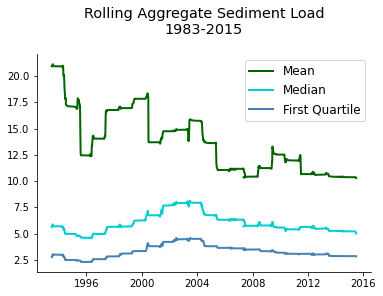

In [37]:
fig_year_rolling_all = plt.figure()
ax = fig_year_rolling_all.add_subplot(1, 1, 1)

ax.plot(rolling_yearly, color='darkgreen', linewidth=2.0, label="Mean")
ax.plot(rolling_yearly_median, color='darkturquoise', linewidth=2.0, label="Median")
ax.plot(rolling_yearly_1q, color='steelblue', linewidth=2.0, label="First Quartile")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title('Rolling Aggregate Sediment Load\n1983-2015', fontdict=titledict, pad=20)
ax.legend(fontsize='large')

plt.show()

Look at the number of samples collected year year to see if it correlateswith yearly trends.

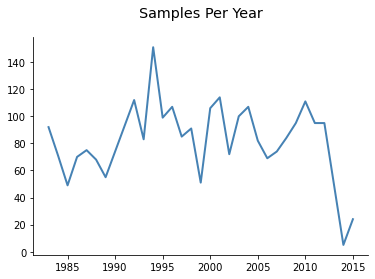

In [38]:
fig_year_samples = plt.figure()
ax = fig_year_samples.add_subplot(1, 1, 1)

ax.plot(sed_data.groupby(sed_data.index.year).Sedload.count(), color='steelblue', linewidth=2.0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title('Samples Per Year', fontdict=titledict, pad=20)

plt.show()

**Discussion**

Yearly trends that use only the average sediment load values show a downward trend of sediment load over all years of data. Yearly averages include high sediment loads from high precipitation.  Yearly median and first quartiles, which are closer to the base sediment load without high precipitation events, show an increase through about 2004, and then a steady decrease.

A significant limitation of this data is not knowing if data was collected after every high precipitation event, or at regular intervals regardless of high precipitation, or both. It's also possible that there were different sample collection practices during different years, dependent on available personnel.  

### Potential for more exploratory data analysis

* Estimate base sediment values to interpolate into a time series with regular frequency
* Compare trends in sediment load with precipitation
* Explore individual high sediment load events